# [BS Side Implementation]-Downlink Time/Frame Synchronization using PSS in 5G Networks

## Import Libraries

### Import Some Basic Python Libraries

In [1]:

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import numpy as np
import adi


### Import 5G Libraries

In [2]:
from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

## Emulation Parameters

In [3]:
# System Parameters
center_frequency    = 1e9 # Hz

# OFDM Parameters
Bandwidth           = 5*10**6
fftSize             = 1024
subcarrier_spacing  = 15000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols) 

## Generate SSB Parameters

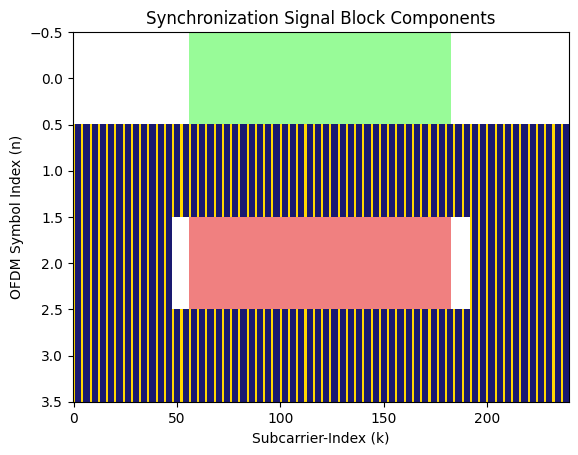

In [4]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
Nfft        = 512                 # FFT-size for OFDM
lengthCP    = tfParams.lengthCP    # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, "caseA", ssbSubCarrierOffset = np.array([0]))

systemFrameNumber               = ssbParameters.systemFrameNumber
subCarrierSpacingCommon         = subcarrier_spacing
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset
choiceBit                       = ssbParameters.choiceBit
ssbType                         = ssbParameters.ssbType
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit
cellBarred                      = ssbParameters.cellBarred
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________


N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)


# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)

## Loading SSB to Resource Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1

ssbRGobject    = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = center_frequency, 
                                   isPairedBand = isPairedBand, 
                                   withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)

ssbGrid = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset[0],
                      offsetInRBs = 0, numRBs = nRB)[0:14]
fig, ax = ssbObject.displayGrid(option=1)

## Construct Transmission Grid and Generate Time Domain Samples

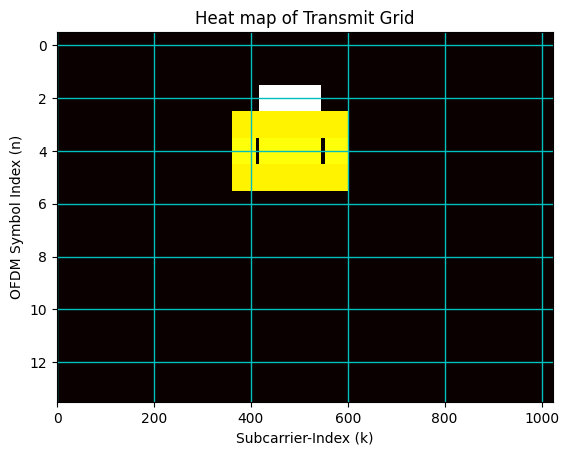

In [5]:
## Loading SSB to Resource Grid
numofGuardCarriers = (int((fftSize - Neff)/2), int((fftSize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)
numOFDMSymbols     = ssbGrid.shape[0]

X = np.zeros((numOFDMSymbols, fftSize), dtype= np.complex64)
X[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = ssbGrid

#__________________________________________________

## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X).flatten()
#______________________________________________________

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## SDR-Setup Configurations

In [6]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo           = int(center_frequency)
sdr.tx_hardwaregain_chan0 = -0 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0   = 40.0      # dB
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

# sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(center_frequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(buffer_size)

## Transmission: SDR RF Transmitter

In [7]:

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
# sdr.tx_cyclic_buffer = False # Enable cyclic buffers
sdr.tx(1.3*2**17*(x_time.repeat(1))) # start transmitting


In [8]:
lengthCP[1]

288